In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [930]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [931]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [932]:
adata.X = adata.layers["counts"].copy()

In [933]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [934]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [935]:
sc.pp.normalize_total(adata)

In [936]:
sc.pp.log1p(adata)

In [937]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [938]:
select_terms = adata.varm['I'].sum(0)>12

In [939]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [940]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [941]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [942]:
adata.X = adata.layers["counts"].copy()

In [943]:
rm_terms = ['INTERFERON_SIGNALING', 
            'INTERFERON_ALPHA_BETA_SIGNALIN',"SIGNALING_BY_THE_B_CELL_RECEPT"]

In [944]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [945]:
for i in ix_f:
    del adata.uns['terms'][i]

In [946]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [947]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [948]:
rm_b = ["CD20+ B cells", "CD10+ B cells"]

In [949]:
adata = adata[~adata.obs.final_annotation.isin(rm_b)]

### Create TRVAE model and train it on reference dataset

In [950]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=0, # add additional unannotated terms in decoder
    n_expand_encoder=0, # same for encoder, should be the same number
    soft_mask=False, # use soft mask 
    use_hsic=False # use hsic,
    
    
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 279
Decoder Architecture:
	Cond layer in, ext, cond, out and :  279 0 4 1972
	with hard mask.


In [951]:
ALPHA = 0.7

In [952]:
OMEGA = None

In [953]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=None, # l1 reg parameter for soft mask
    gamma_ext=0.6, # l1 reg parameter on unannotated terms
    alpha_kl=0.5,
    beta=1., # hsic reg parameter
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=False,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss:  884.52 - epoch_recon_loss:  857.96 - epoch_kl_loss:   53.13 - val_loss:  925.97 - val_recon_loss:  898.62 - val_kl_loss:   54.69
Saving best state of network...
Best State was in Epoch 197


In [954]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [955]:
#ext_active = (intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 12

In [956]:
#inactive_idx[-len(ext_active):] = ~ext_active

In [957]:
#adata.uns['terms'] += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [958]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'ACTIVATED_NOTCH1_TRANSMITS_SIG',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'TGF_BETA_RECEPTOR_SIGNALING_AC',
 'CHONDROITIN_SULFATE_DERMATAN_S',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'HEPARAN_SULFATE_HEPARIN_HS_GAG',
 'BASIGIN_INTERACTIONS',
 'PHOSPHORYLATION_OF_CD3_AND_TCR',
 'ERK_MAPK_TARGETS',
 'REGULATION_OF_ORNITHINE_DECARB',
 'REGULATION_OF_APOPTOSIS',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'CA_DEPENDENT_EVENTS',
 'G1_PHASE',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'NUCLEOTIDE_EXCISION_REPAIR',
 'REGULATION_OF_INSULIN_SECRETIO',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'SEMA4D_INDUCED_CELL_MIGRATION_',
 'SIGNALING_BY_ROBO_RECEPTOR',
 'CD28_DEPENDENT_PI3K_AKT_SIGNAL',
 'CTLA4_INHIBITORY_SIGNALI

In [959]:
MEAN = False

In [960]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [961]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [962]:
sc.tl.umap(adata)

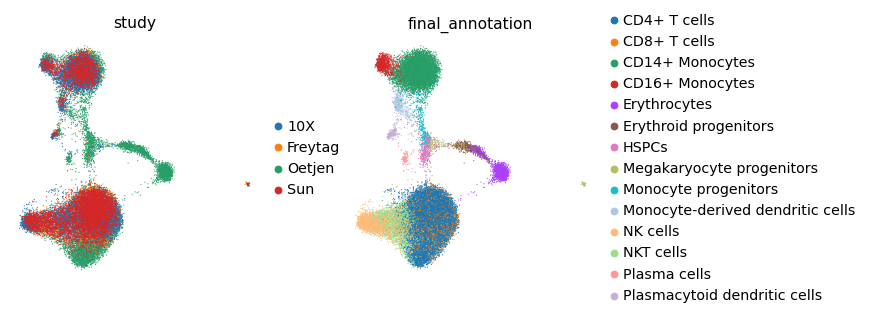

In [963]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [965]:
intr_cvae.save('model_wo_hsic_ref_BINF')

In [966]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [967]:
kang.obs['study'] = 'Kang'

In [968]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [969]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae,
                                               unfreeze_ext=True, # do not freeze the unannotated terms weights
                                               new_n_ext_decoder=6,
                                               new_n_expand_encoder=6)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 279
	Expanded Mean/Var Layer in/out: 300 6
Decoder Architecture:
	Cond layer in, ext, cond, out and :  279 6 5 1972
	with hard mask.


In [970]:
hsic = False
q_intr_cvae.use_hsic_ = hsic
q_intr_cvae.model.use_hsic = hsic
q_intr_cvae.hsic_one_vs_all_= hsic
q_intr_cvae.model.hsic_one_vs_all = hsic

In [971]:
q_intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=50, 
    weight_decay=0., 
    alpha_kl=0.2,
    gamma_ext=0.70,
    beta=3,
    seed=2020,
    use_early_stopping=False,
    print_n_deactive=True,
    use_hisc= hsic 
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Active genes in extension terms: [1886 1877 1918 1890 1907 1901]
Sparcity share in extension terms: [0.04 0.05 0.03 0.04 0.03 0.04]
 |--------------------| 0.5%  - epoch_loss: 1048.34 - epoch_recon_loss: 1048.34 - epoch_kl_loss:   74.20 - val_loss:  711.23 - val_recon_loss:  711.23 - val_kl_loss:   99.35Active genes in extension terms: [1396 1379 1485 1431 1559 1428]
Sparcity share in extension terms: [0.29 0.3  0.25 0.27 0.21 0.28]
 |--------------------| 1.0%  - epoch_loss:  602.69 - epoch_recon_loss:  602.14 - epoch_kl_loss:  137.02 - val_loss:  558.24 - val_recon_loss:  557.56 - val_kl_loss:  170.53Active genes in extension terms: [1031  991 1144 1101 1204 1044]
Sparcity share in extension terms: [0.48 0.5  0.42 0.44 0.39 0.47]
 |--------------------| 1.5%  - epoch_loss:  559.59 - epoch_recon_loss:  557.94 - epoch_kl_loss:  207.01 - val_loss:  554.57 - val_recon_loss:  552.62 - val_kl_loss:  243.45Active genes in extension terms: [ 889  787 1064  993 1152  896]
Sparcity share in ex

In [972]:
q_intr_cvae.save('model_wo_hsic_ref_q_BINF')

In [973]:
ext_active = (q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 30

In [974]:
inactive_idx = ~q_intr_cvae.model.decoder.nonzero_terms()

In [975]:
inactive_idx[-len(ext_active):] = ~ext_active

In [976]:
terms = adata.uns['terms'].copy()

In [977]:
terms += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [978]:
#q_intr_cvae.save('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020_rm5')

In [979]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [980]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [981]:
sc.tl.umap(kang)

... storing 'study' as categorical


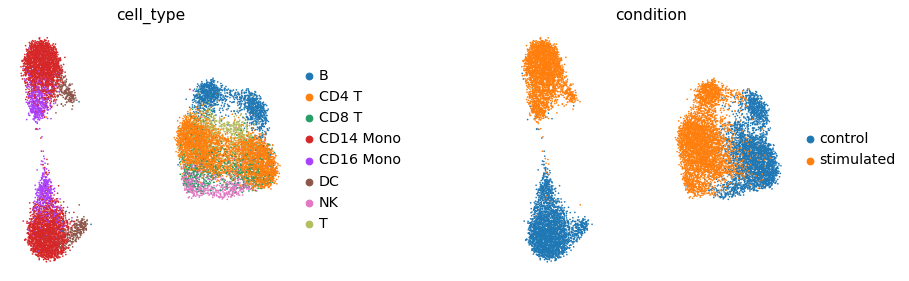

In [982]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [983]:
ext_active

array([ True, False,  True, False,  True, False])

In [1041]:
# select unannotated term to plot
idx = [terms.index(term) for term in [ 'unannotated_0','unannotated_2',
                                      'unannotated_4']]

In [1042]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

In [1043]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]
kang.obs['IFN'] = latents[:, 0]
kang.obs['B'] = latents[:, 1]
kang.obs['Myeloid'] = latents[:, 2]


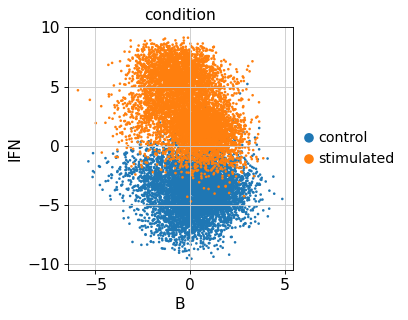

In [1044]:
sc.pl.scatter(kang, x='B', y='IFN', color='condition', size=22)

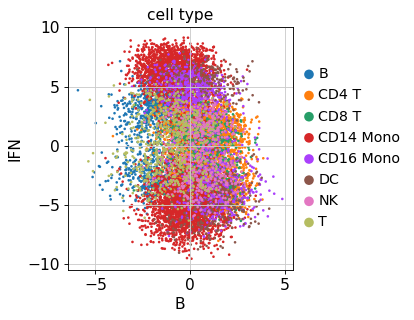

In [1045]:
sc.pl.scatter(kang, x='B', y='IFN', color='cell_type', size=22)

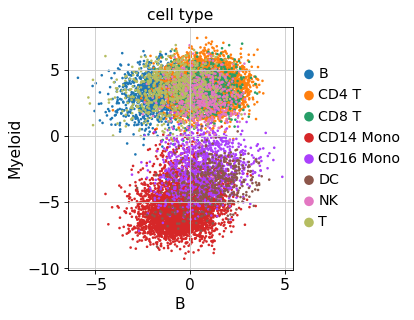

In [1046]:
sc.pl.scatter(kang, x='B', y='Myeloid', color='cell_type', size=22)

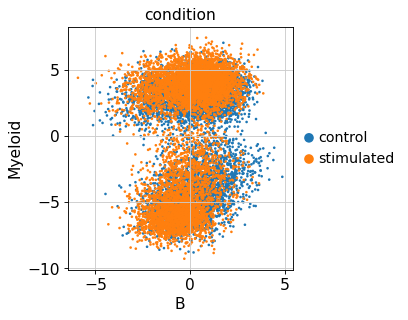

In [1047]:
sc.pl.scatter(kang, x='B', y='Myeloid', color='condition', size=22)

In [1048]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [1049]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [1066]:
latents.shape

(42980, 3)

In [1050]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [1051]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [1052]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [1053]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [1054]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [1055]:
categories

array(['B', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD4 T', 'CD4+ T cells', 'CD8 T',
       'CD8+ T cells', 'DC', 'Erythrocytes', 'Erythroid progenitors',
       'HSPCs', 'Megakaryocyte progenitors', 'Monocyte progenitors',
       'Monocyte-derived dendritic cells', 'NK', 'NK cells', 'NKT cells',
       'Plasma cells', 'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [1056]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [1057]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [ ]:
palette=['steelblue', 'skyblue', 'red']

... storing 'cell_type_joint' as categorical


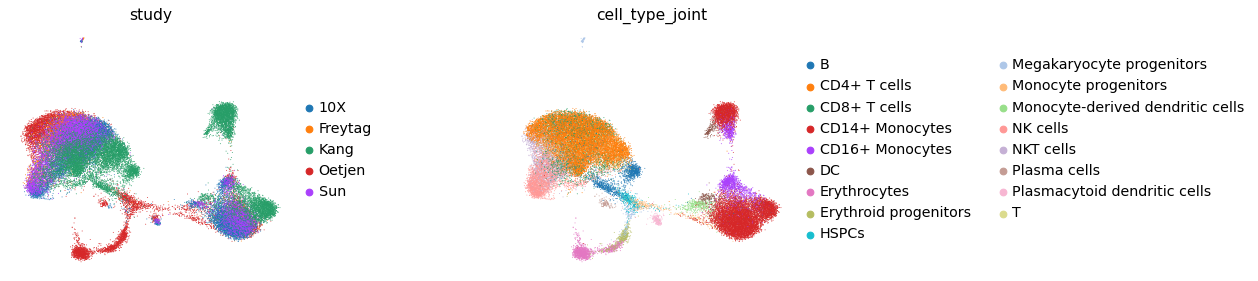

In [1058]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

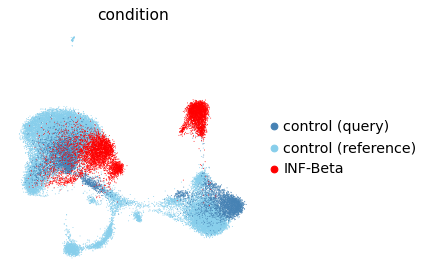

In [1073]:
sc.pl.umap(kang_pbmc, color='condition',
           frameon=False, wspace=0.6, palette=['steelblue', 'skyblue', 'red'] )

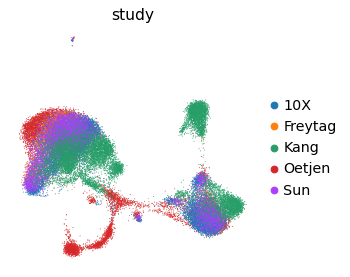

In [1059]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

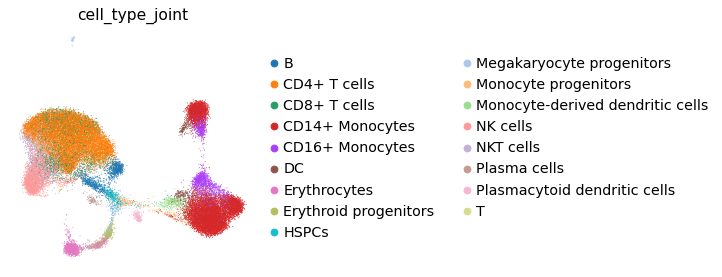

In [1060]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

In [1061]:
kang_pbmc.rename_categories("condition",['control (query)', 'control (reference)', 'INF-Beta'])

In [1068]:

latents =  q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, idx]
kang_pbmc.obs['IFN'] = latents[:, 0]
kang_pbmc.obs['B'] = latents[:, 1]
kang_pbmc.obs['Myeloid'] = latents[:, 2]


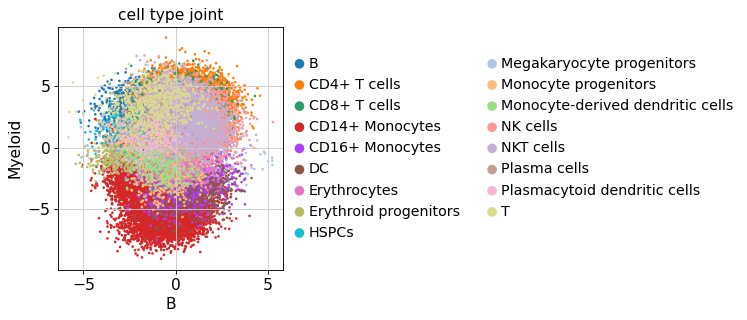

In [1081]:
sc.pl.scatter(kang_pbmc, x='B', y='Myeloid',
              color='cell_type_joint',
              size=22)

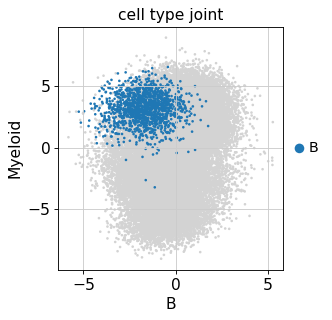

In [1080]:
sc.pl.scatter(kang_pbmc, x='B', y='Myeloid',
              color='cell_type_joint',
              size=22,
             groups="B")

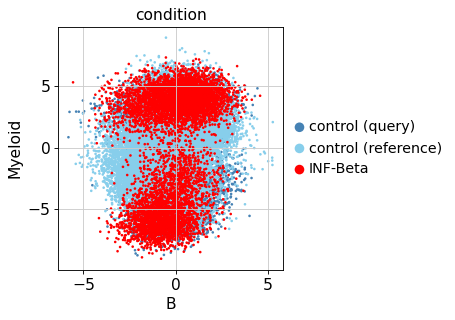

In [1074]:
sc.pl.scatter(kang_pbmc, x='B', y='Myeloid', color='condition', size=22)

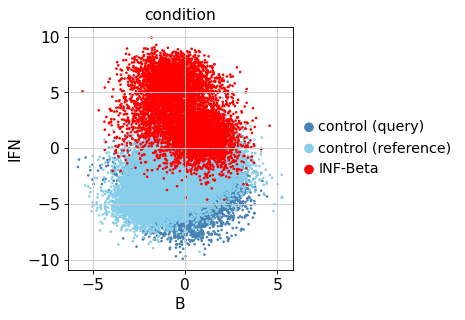

In [1075]:
sc.pl.scatter(kang_pbmc, x='B', y='IFN', color='condition', size=22)

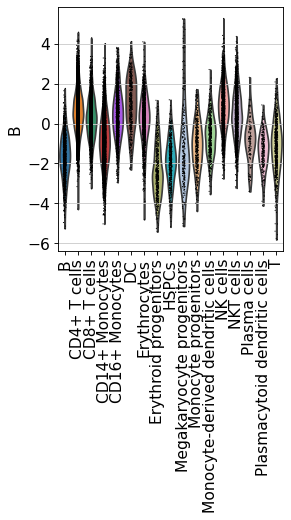

In [1078]:
sc.pl.violin(kang_pbmc, keys="B",
             groupby="cell_type_joint", rotation=90)

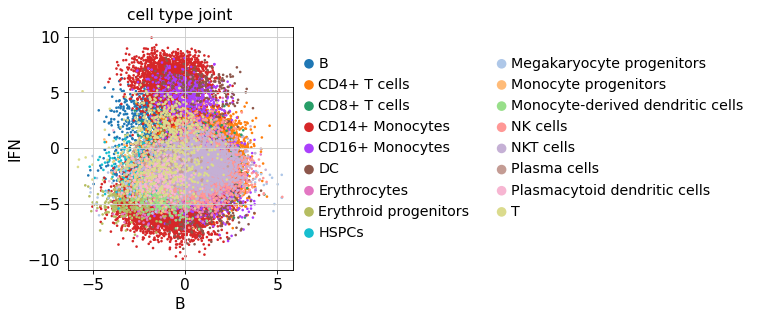

In [1076]:
sc.pl.scatter(kang_pbmc, x='B', y='IFN', color='cell_type_joint', size=22)

In [1037]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [1038]:
kang_pbmc.write('kang_pbmc_integrated_wo_hsic_infB.h5ad')

In [929]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [856]:
IFN_A_B_GENES = ['ISG15', 'IFI6', 'JAK1', 'GBP2', 'ADAR', 'STAT1', 'IRF2', 'IRF1', 'EGR1', 'IRF4', 
                 'HLA-F', 'HLA-G', 'HLA-A', 'HLA-C', 'HLA-B', 'IRF5', 'IFITM2', 'IFITM1', 'IFITM3', 
                 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'PTPN6', 'STAT2', 'OAS1', 'OAS3', 'OAS2', 'OASL',
                 'IRF9', 'IFI27', 'ISG20', 'SOCS1', 'IRF8', 'XAF1', 'IFI35', 'SOCS3', 'PTPN1', 'TYK2', 
                 'IRF3', 'USP18', 'IFNAR2', 'IFNAR1', 'MX2', 'MX1']

In [871]:
unann_idx = 3

In [872]:
import seaborn as sns

In [873]:
x=q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [874]:
x = q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [875]:
x

tensor(0.008, device='cuda:0')

<AxesSubplot:ylabel='Count'>

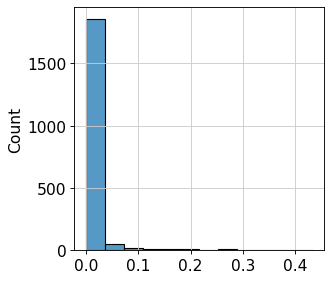

In [876]:
sns.histplot(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu())

In [877]:
unann_genes = adata.var_names[(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx]>x).cpu().numpy()].tolist()

In [878]:
len(unann_genes)

193

In [879]:
len(set(unann_genes).intersection(IFN_GENES))

38

In [880]:
len(set(unann_genes).intersection(IFN_A_B_GENES))

26

In [881]:
srt = np.argsort(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu().numpy())[::-1]

In [882]:
unann_genes_top = adata.var_names[srt[:100]].tolist()

In [883]:
len(set(unann_genes_top).intersection(IFN_GENES))

34

In [884]:
len(set(unann_genes_top).intersection(IFN_A_B_GENES))

26